In [1]:
import tensorflow as tf
import cv2
import os
import sys
import random
import numpy as np
import glob

from tqdm import tqdm
from patchify import patchify
import tifffile as tif
from PIL import Image
from skimage.io import imread,imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.models import Model

In [2]:
size_x=128
size_y=128

In [3]:
################# Storing Train Images into an array #############
train_images=[]

for directory_path in glob.glob("Dataset_BUSI_with_GT/data_for_training_and_testing/train/images"):
    for img_path in glob.glob(os.path.join(directory_path,"*.png")):
        #print(img_path)
        img=cv2.imread(img_path,cv2.IMREAD_COLOR)
        img=cv2.resize(img,(size_y, size_x))
        train_images.append(img)
        
train_images = np.array(train_images) #converting list to array

In [4]:
################# Storing Train Masks into an array #############
train_masks = []

for directory_path in glob.glob("Dataset_BUSI_with_GT/data_for_training_and_testing/train/masks"):
    for mask_path in glob.glob(os.path.join(directory_path,"*.png")):
        mask=cv2.imread(mask_path,0)
        mask=cv2.resize(mask,(size_y,size_x))
        train_masks.append(mask)
        
train_masks = np.array(train_masks) #converting list to array

In [5]:
########## Renaming variables to traditional  names ############
X_train = train_images
Y_train = train_masks
Y_train = np.expand_dims(Y_train,axis=3)

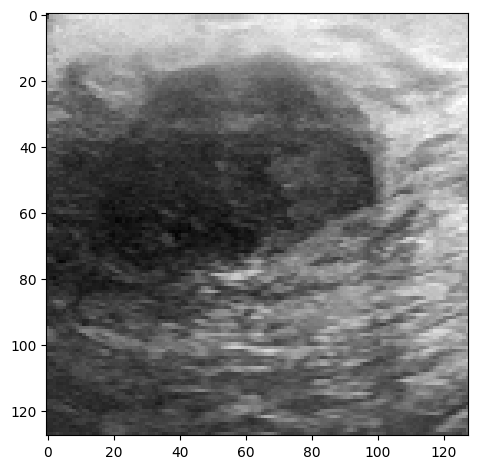

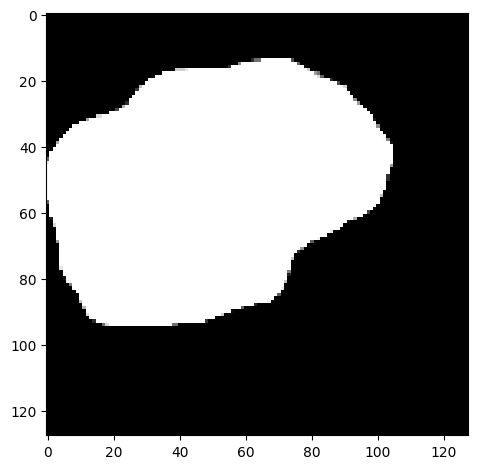

0.01568627450980392 1.0
(128, 128, 3)
0.0 1.0
(128, 128, 1)


In [6]:
########## Displaying random image from X_train and Y_train ######### 

X_train=X_train/255
Y_train=Y_train/255
random_num = random.randint(0,516)
imshow(X_train[random_num])
plt.show()
imshow(Y_train[random_num])
plt.show() 

test_img = X_train[random_num]
test_img2 = Y_train[random_num]
print(test_img.min(), test_img.max())
print(test_img.shape)

print(test_img2.min(), test_img2.max())
print(test_img2.shape)


In [7]:
####################### Building Model ############################

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()
    
    return model

In [8]:
def get_model():
    return simple_unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [9]:
model = get_model()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
######################Training Model####################################
history = model.fit(X_train, Y_train, 
                    epochs=50,
                    batch_size = 50, 
                    verbose=1, 
                    validation_split=0.1,
                    shuffle=True)

Epoch 1/50
10/10 [==============================] - 36s 3s/step - loss: 0.4938 - accuracy: 0.8357 - val_loss: 0.4208 - val_accuracy: 0.8775
Epoch 2/50
10/10 [==============================] - 32s 3s/step - loss: 0.3365 - accuracy: 0.9086 - val_loss: 0.4072 - val_accuracy: 0.8775
Epoch 3/50
10/10 [==============================] - 32s 3s/step - loss: 0.3237 - accuracy: 0.9086 - val_loss: 0.3885 - val_accuracy: 0.8775
Epoch 4/50
10/10 [==============================] - 34s 3s/step - loss: 0.3042 - accuracy: 0.9086 - val_loss: 0.3218 - val_accuracy: 0.8775
Epoch 5/50
10/10 [==============================] - 33s 3s/step - loss: 0.3147 - accuracy: 0.9080 - val_loss: 0.3566 - val_accuracy: 0.8775
Epoch 6/50
10/10 [==============================] - 34s 3s/step - loss: 0.2827 - accuracy: 0.9089 - val_loss: 0.3415 - val_accuracy: 0.8775
Epoch 7/50
10/10 [==============================] - 34s 3s/step - loss: 0.2342 - accuracy: 0.9105 - val_loss: 0.3772 - val_accuracy: 0.8775
Epoch 8/50
10/10 [==

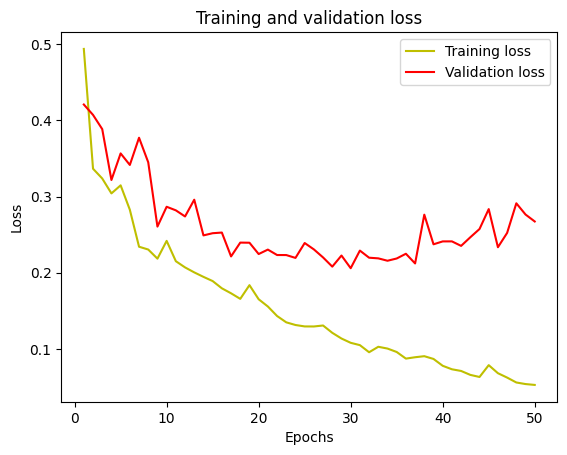

In [14]:
#plot the training and validation loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

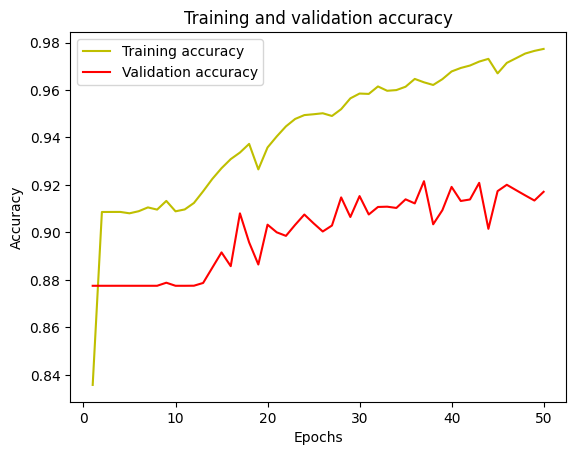

In [50]:
#plot the training and validation accuracy at each epoch
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

1/1 [==============================] - 0s 73ms/step


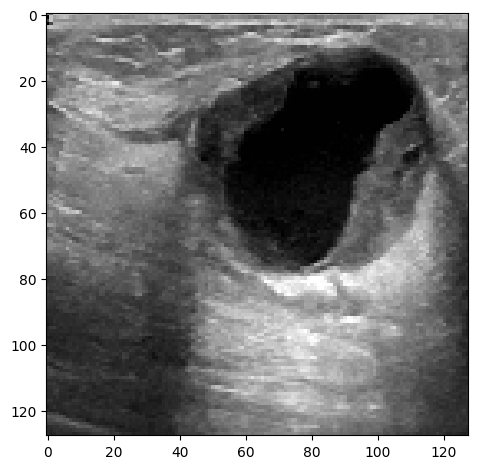

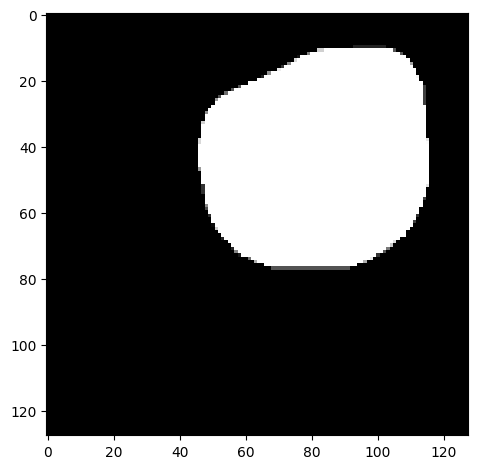

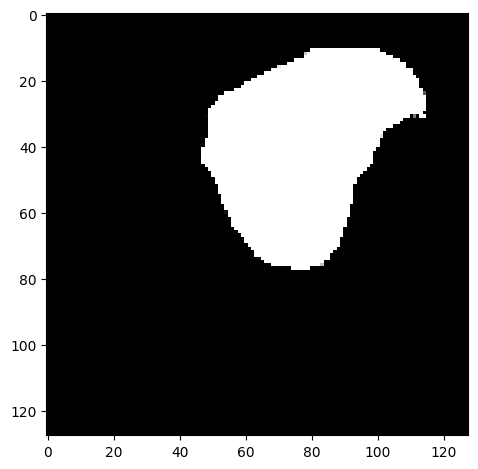

In [52]:
#testing model prediction on an unseen image

#163, 54, 92, 213, 412
test_actual_img = cv2.imread('Dataset_BUSI_with_GT/data_for_training_and_testing/val/images/benign (73).png', cv2.IMREAD_COLOR)
test_actual_mask= cv2.imread('Dataset_BUSI_with_GT/data_for_training_and_testing/val/masks/benign (73)_mask.png', cv2.IMREAD_COLOR)
test_img = cv2.imread('Dataset_BUSI_with_GT/data_for_training_and_testing/val/images/benign (73).png', cv2.IMREAD_COLOR)       
test_img = cv2.resize(test_img, (size_y, size_x))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)
prediction = model.predict(test_img)

#View and Save segmented image
test_actual_img=cv2.resize(test_actual_img,(size_y,size_x))
imshow(test_actual_img)
plt.show()

test_actual_mask=cv2.resize(test_actual_mask,(size_y,size_x))
imshow(test_actual_mask, cmap='gray')
plt.show()

prediction_image = prediction.reshape(mask.shape)
imshow(prediction_image, cmap='gray')
plt.show()